# Chapter 1

In [1]:
from cProfile import label

import requests_cache
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import acf

In [2]:
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-Leonardo'] = 'Chapter_1'

In [3]:
stoxx50e_data = yf.download('^STOXX50E')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# stoxx50e_data.to_excel(r"C:\Users\leocr\Projects\Economics\Finance\Risk Management\data_stoxx50e.xlsx")

In [4]:
prices = stoxx50e_data.Close['^STOXX50E']
prices

Date
2007-03-30    4181.029785
2007-04-02    4189.549805
2007-04-03    4246.299805
2007-04-04    4261.830078
2007-04-05    4271.540039
                 ...     
2025-02-24    5453.759766
2025-02-25    5447.899902
2025-02-26    5527.990234
2025-02-27    5472.560059
2025-02-28    5463.540039
Name: ^STOXX50E, Length: 4493, dtype: float64

In [5]:
prices.describe()

count    4493.000000
mean     3387.685643
std       709.582645
min      1809.979980
25%      2875.939941
50%      3324.860107
75%      3781.790039
max      5533.839844
Name: ^STOXX50E, dtype: float64

In [6]:
prices = prices.to_numpy()

In [7]:
dates = stoxx50e_data.Close['^STOXX50E'].index

## Returns

In [8]:
returns = np.log(prices[1:])- np.log(prices[:-1])
mean = returns.mean()
variance = returns.var()
print('average = ',mean, '\nvariance = ', variance)

average =  5.9559074395698434e-05 
variance =  0.00019448892995148706


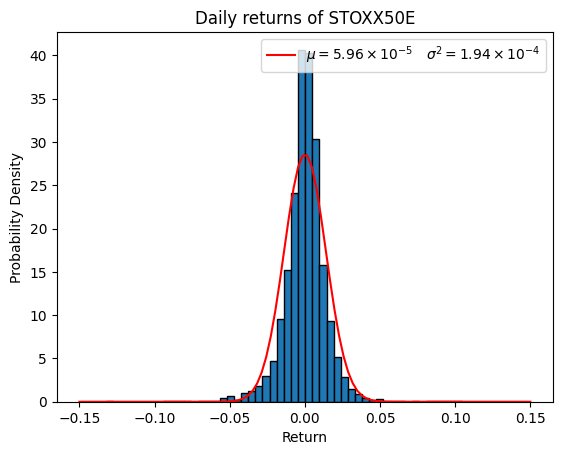

In [9]:
# Generate a range of x values for the normal distribution
x = np.linspace(-0.15, 0.15, 100)
# Evaluate the normal distribution at the x values
y = sp.stats.norm(loc =mean, scale = np.sqrt(variance)).pdf(x)

# Plot the histogram
plt.hist(returns, bins=50, edgecolor='black', density=True)
# Plot the fitted distribution
plt.plot(x, y, 'r-', label=r'$\mu = 5.96\times 10^{-5} \quad \sigma^2 = 1.94\times 10^{-4}$')
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.title('Daily returns of STOXX50E')
plt.legend()
plt.show()

## Autocorrelations

In [10]:
max_lag = 100
# Calculate autocorrelation for lags 1 to 100
autocorr_values = acf(returns, nlags=max_lag)

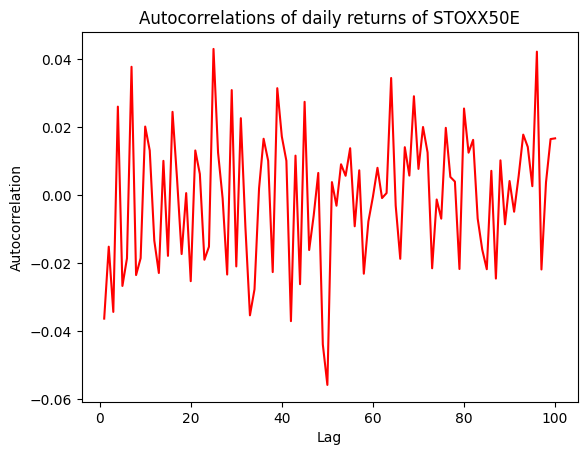

In [11]:
x = np.arange(max_lag+1)

plt.plot(x[1:], autocorr_values[1:], 'r-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelations of daily returns of STOXX50E')
plt.show()

## Squared Autocorrelations

In [12]:
# Calculate autocorrelation for lags 1 to 100
sq_autocorr_values = acf(returns**2, nlags=max_lag)

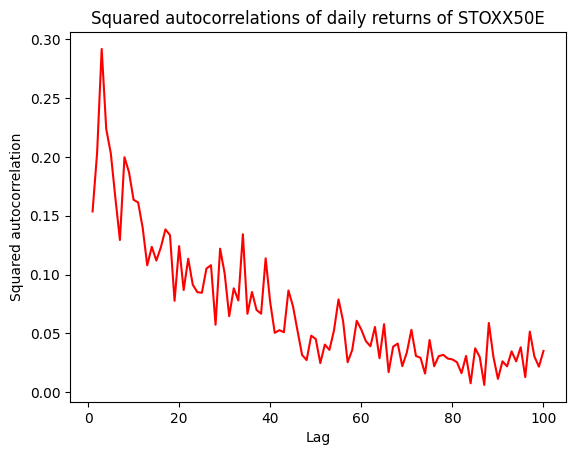

In [13]:
plt.plot(x[1:], sq_autocorr_values[1:], 'r-')
plt.xlabel('Lag')
plt.ylabel('Squared autocorrelation')
plt.title('Squared autocorrelations of daily returns of STOXX50E')
plt.show()

## Riskmetrics

In [14]:
def risk_metrics(returns, persistence):
    t_max = len(returns)
    volatility = np.zeros(t_max)
    volatility[0] = returns.var()
    for t in range(1, t_max):
        volatility[t] = persistence*volatility[t-1] + (1-persistence)*returns[t]**2
    return volatility

In [15]:
volatility = risk_metrics(returns, 0.94)

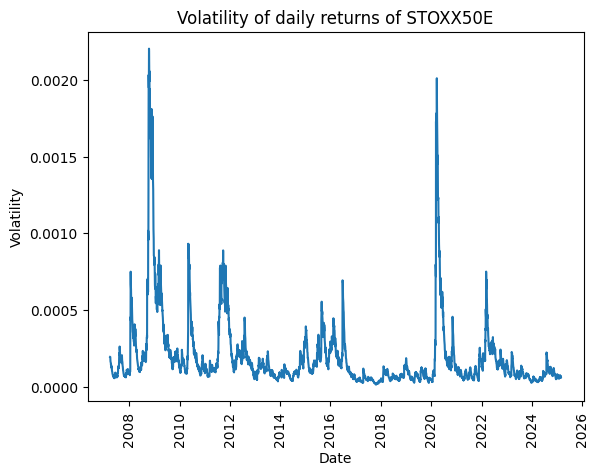

In [16]:
plt.plot(dates[:-1],volatility)
# rotate x-tick-labels by 90°
plt.tick_params(axis='x',rotation=90)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of daily returns of STOXX50E')
plt.show()

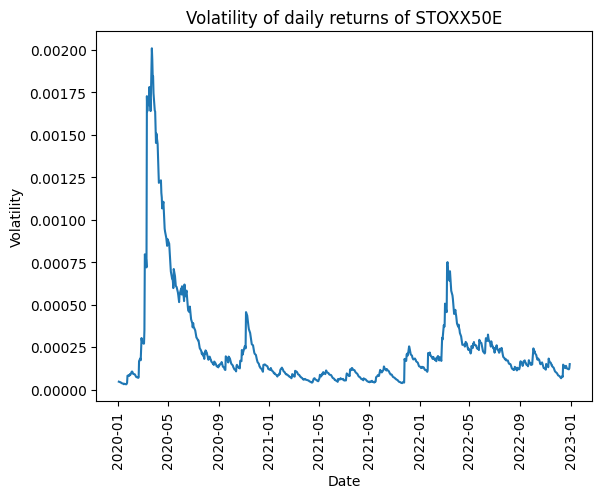

In [50]:
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2022-12-31')

mask = (dates[:-1] >= start_date) & (dates[:-1] <= end_date)

plt.plot(dates[:-1][mask], volatility[mask])
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of daily returns of STOXX50E')
plt.show()

## RM VaR
RiskMetrics VaR assuming gaussian distribution of portfolio returns

In [103]:
p = 0.01
#quantile = sp.stats.norm.ppf(p, loc=mean, scale=np.sqrt(variance))
quantile = sp.stats.norm.ppf(p, loc=0, scale=1)
print(-quantile)

2.3263478740408408


## HS VaR

VaR from historical simulation

In [112]:
len_ret = len(returns)
hs_var = np.zeros(len_ret)
hs_span = 250

for t in range(1,len_ret-hs_span):
    hs_var[t+hs_span] = -np.percentile(returns[t:t+hs_span], 100*p)/5

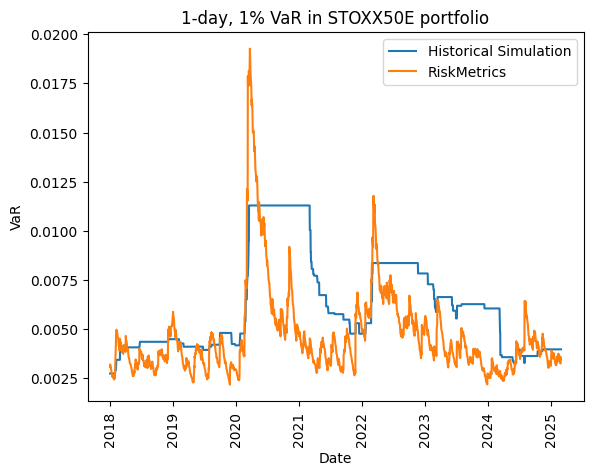

In [113]:
plt.plot(dates[:-1][mask],  hs_var[mask], label = 'Historical Simulation')
plt.plot(dates[:-1][mask], -quantile ** (-1) *np.sqrt(volatility[mask]), label = 'RiskMetrics')
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('1-day, 1% VaR in STOXX50E portfolio')
plt.legend()
plt.show()

# Chapter 2

## HS - Using Pseudo Returns

Find data for all the components of EUROSTOXX50

In [20]:
# Open the file in read mode
with open('Tickers', 'r') as file:
    # Read all lines into a list and strip newline characters
    tickers = [line.strip() for line in file.readlines()]

# Print the list of tickers
print(len(tickers))


50


In [21]:
# Download data for all tickers
data = yf.download(tickers, period='1d')

[*********************100%***********************]  50 of 50 completed


In [22]:
market_caps = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info.get("marketCap", 0)

In [23]:
# Convert to DataFrame
df = pd.DataFrame(market_caps.items(), columns=["Ticker", "MarketCap"])
df["Weight"] = df["MarketCap"] / df["MarketCap"].sum() * 100  # Normalize weights
df = df.sort_values(by="Weight", ascending=False)

print(df)

       Ticker     MarketCap    Weight
27      MC.PA  347024719872  7.850267
36     SAP.DE  312061755392  7.059347
6     ASML.AS  274886590464  6.218384
26     LIN.DE  210445844480  4.760629
29      OR.PA  188612132864  4.266715
37     SIE.DE  173247610880  3.919144
24     ITX.MC  161879638016  3.661982
44     UNA.AS  134145957888  3.034601
30  ORSTED.CO  132458078208  2.996418
39      SU.PA  131996696576  2.985981
14      EL.PA  131676766208  2.978744
35     SAN.PA  131426811904  2.973089
4      AIR.PA  130564300800  2.953578
41     TTE.PA  128988651520  2.917934
5      ALV.DE  128709312512  2.911615
0      ABI.BR  113030881280  2.556943
34     SAF.PA  103903543296  2.350468
3       AI.PA  101815951360  2.303243
21     IBE.MC   88751022080  2.007693
49    ZURN.SW   84460363776  1.910632
23     ISP.MI   84388913152  1.909015
10     BNP.PA   82299011072  1.861738
42     UCG.MI   79223373824  1.792162
8     BBVA.MC   73828646912  1.670125
28    MUV2.DE   73354264576  1.659393
15    ENEL.M

In [24]:
# Download data for all tickers
historical_data = yf.download(tickers, start='2010-01-01').fillna(0)

[*********************100%***********************]  50 of 50 completed


In [25]:
hs_dates = historical_data.Close[tickers[0]].index

In [26]:
pseudo_values = 0
for index, row in df.iterrows():
    historical_prices = historical_data.Close[row["Ticker"]].to_numpy()
    pseudo_values= pseudo_values + historical_prices*row["Weight"]
print(len(pseudo_values))

3919


In [27]:
for i in range(len(pseudo_values)):
    pv = pseudo_values[i]
    if pv<=0:
        print(i,pv)
        
print(np.log(pseudo_values))

[ 8.77267255  8.76353532  8.75785955 ... 10.94706694 10.94708841
 10.9443872 ]


In [28]:
pseudo_returns = np.log(pseudo_values[1:])-np.log(pseudo_values[:-1])
pr_mean =pseudo_returns.mean()
pr_variance = pseudo_returns.var()
print(pr_mean,pr_variance)

0.0005542916415614829 0.7309173645644041


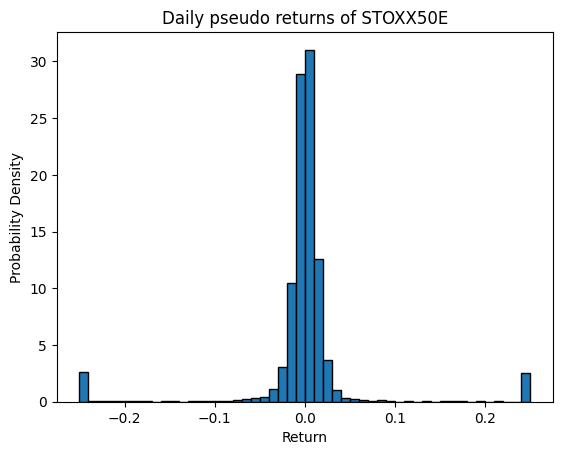

In [29]:
# Plot the histogram
plt.hist(np.clip(pseudo_returns,-0.25,0.25), bins=50, edgecolor='black', density=True)
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.title('Daily pseudo returns of STOXX50E')
plt.show()

In [117]:
len_pr = len(pseudo_returns)
hs_var = np.zeros(len_pr)
hs_span = 250

for t in range(1,len_pr-hs_span):
    hs_var[t+hs_span] = -np.percentile(pseudo_returns[t:t+hs_span], 100*p)

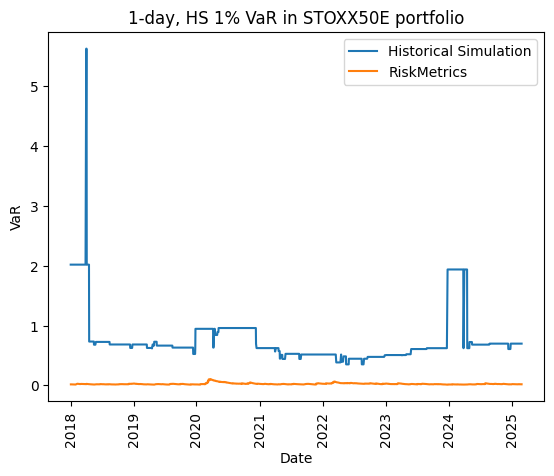

In [118]:
start_date = np.datetime64('2018-01-01')
end_date = np.datetime64('2025-12-31')

mask = (dates[:-1] >= start_date) & (dates[:-1] <= end_date)
hs_mask = (hs_dates[:-1] >= start_date) & (hs_dates[:-1] <= end_date)

plt.plot(hs_dates[:-1][hs_mask], hs_var[hs_mask], label = 'Historical Simulation')
plt.plot(dates[:-1][mask], -quantile * np.sqrt(volatility[mask]), label = 'RiskMetrics')
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('1-day, HS 1% VaR in STOXX50E portfolio')
plt.legend()
plt.show()